In [18]:
#install the following packages if you do not have them installed
!pip install matplotlib
!pip install pandas
!pip install pandas-datareader
!pip install PyPortfolioOpt

  Using cached matplotlib-3.4.2-cp37-cp37m-win_amd64.whl (7.1 MB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-win_amd64.whl (51 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [1]:
!python --version

Python 3.7.10


In [2]:
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from pypfopt import  EfficientSemivariance
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting


In [3]:
def get_stock(tickers,start,end):
    stocks = web.DataReader(tickers,
                        'yahoo', start, end)['Adj Close']
    return stocks

In [4]:
start = dt.datetime(2013, 1, 1)
end = dt.datetime(2021, 5, 1)

tickers = ['AAPL', 'AMZN', 'MSFT', 'GOOGL','FB','GOOG','PG','JPM','TSLA','JNJ']
df=get_stock(tickers,start,end)

In [5]:
df.head()

Symbols,AAPL,AMZN,MSFT,GOOGL,FB,GOOG,PG,JPM,TSLA,JNJ
Date,,,,,,,,,,
2013-01-02,17.010899,257.309998,23.074232,361.987000,28.000000,360.274597,53.704983,35.562012,7.072,56.070381
2013-01-03,16.796177,258.480011,22.765125,362.197205,27.770000,360.483826,53.364449,35.490330,6.954,55.991253
2013-01-04,16.328323,259.149994,22.339064,369.354340,28.760000,367.607117,53.472805,36.119392,6.880,56.632359
2013-01-07,16.232281,268.459991,22.297297,367.742737,29.420000,366.003143,53.109035,36.159210,6.868,56.513645
2013-01-08,16.275965,266.380005,22.180330,367.017029,29.059999,365.280823,53.023914,36.230877,6.736,56.521553


<AxesSubplot:xlabel='Symbols'>

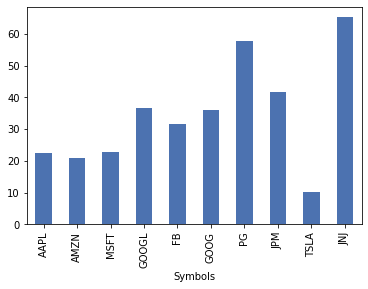

In [6]:
def sharpe_ratio(return_series, num_days, risk_free):
    mean = return_series.mean() * num_days  - risk_free
    sigma = return_series.std() * np.sqrt(num_days)
    return mean / sigma

num_days = 255 #255 trading days in a year
risk_free =0.01 #1% risk free rate
sharpes = df.apply(sharpe_ratio, args=(num_days,risk_free,),axis=0)

sharpes.plot.bar()

In [7]:
def get_sortino_ratio(my_series,num_days,risk_free):
    mean = my_series.mean() * num_days -risk_free
    daily_change=my_series.pct_change()
    std_neg=np.prod(daily_change+1)-1
    std_neg = my_series.min().std()*np.sqrt(num_days)
    return mean/std_neg

In [8]:
sortinos=get_sortino_ratio(df,num_days,risk_free)

Text(0, 0.5, 'Sortino Ratio')

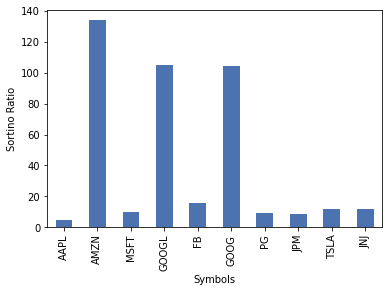

In [9]:
sortinos.plot.bar()
plt.ylabel('Sortino Ratio')

Symbols,AAPL,AMZN,MSFT,GOOGL,FB,GOOG,PG,JPM,TSLA,JNJ,Port
Date,,,,,,,,,,,
2021-04-30,7.714883,13.475652,10.903896,6.501615,11.61,6.689675,2.484313,4.325121,100.316742,2.88425,10.548333


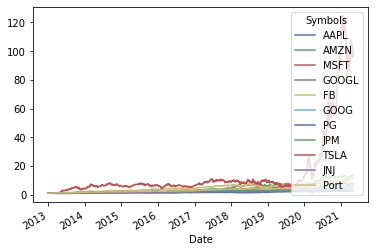

In [11]:
df = df.pct_change().dropna()
df['Port'] = df.mean(axis=1) # 20% apple, ... , 20% facebook
(df+1).cumprod().plot()

(df+1).cumprod()[-1:]

Text(0, 0.5, 'Max Drawdown')

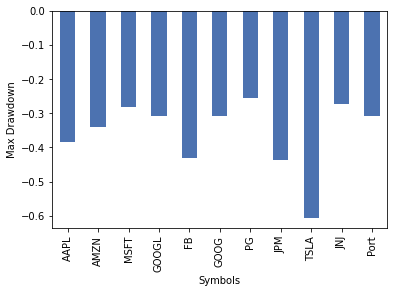

In [12]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()


max_drawdowns = df.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')

Text(0, 0.5, 'Calmar ratio')

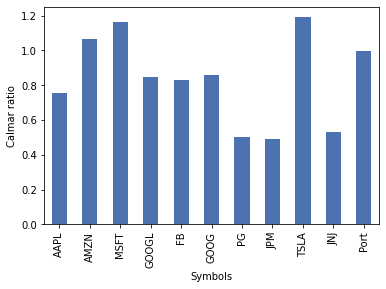

In [13]:
calmars = df.mean()*255/abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')

In [14]:
conDf=pd.concat([sortinos,sharpes,max_drawdowns,calmars],axis=1)

In [15]:
conDf.columns=['Sortino Ratio','Sharpe Ratio','Max Drawdowns','Calmer Ratio']#add columns to dataframe

In [16]:
conDf.dropna()

,Sortino Ratio,Sharpe Ratio,Max Drawdowns,Calmer Ratio
Symbols,,,,
AAPL,4.815542,22.499638,-0.385159,0.753936
AMZN,134.005150,21.017744,-0.341038,1.065526
MSFT,9.696415,22.702545,-0.280393,1.162971
GOOGL,105.081699,36.736451,-0.308708,0.846344
FB,15.440676,31.564837,-0.429609,0.832418
GOOG,104.119698,35.966985,-0.307901,0.860317
PG,9.405556,57.608538,-0.254642,0.500441
JPM,8.671518,41.785190,-0.436265,0.492130
TSLA,11.689146,10.186571,-0.606265,1.191221


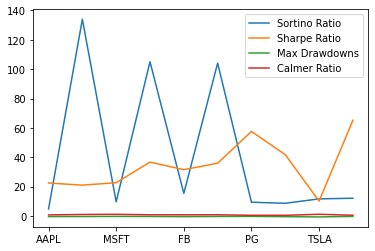

In [29]:
conDf.dropna().plot()

<AxesSubplot:xlabel='Symbols'>

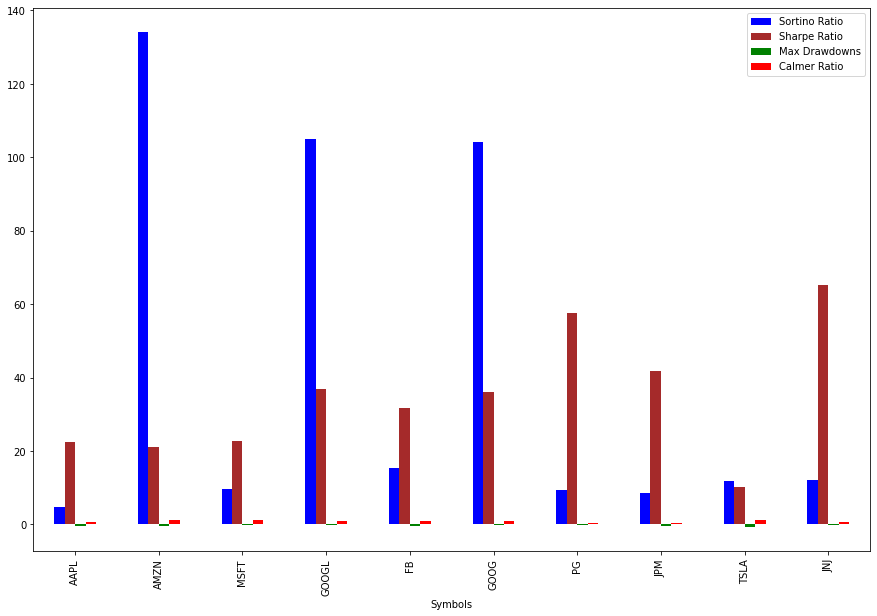

In [37]:
color=['blue','brown','green','red']
conDf.dropna().plot.bar(figsize=(15,10),color=color)

In [ ]:
mu = expected_returns.mean_historical_return(df)

#mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()

historical_returns = expected_returns.returns_from_prices(df)

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.20)

# We can use the same helper methods as before
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

##############################
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))


In [ ]:
#bar chart of weights
plotting.plot_weights(weights,ax=None)
plt.show()

In [ ]:
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()